
## Final Project Submission

Please fill out:
* Student name: Srinivasan Ramakrishnan and Diego Rangel
* Student pace: full time
* Scheduled project review date/time: January 26, 2023/4pm
* Instructor name: Brendan Hutchinson
* Blog post URL:



In [116]:
# Your code here - remember to use markdown cells for comments as well!
# Importing all the packages
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [117]:
# Looking for the data folder content in directory
!ls data

bom.movie_gross.csv
im.db
rt.movie_info.tsv
rt.reviews.tsv
tmdb.movies.csv
tn.movie_budgets.csv


In [118]:
# Reading all the data files through pandas
bom_mov = pd.read_csv("data/bom.movie_gross.csv")
rt = pd.read_csv("data/rt.movie_info.tsv", sep='\t')
rt_rev = pd.read_table("data/rt.reviews.tsv", encoding= 'latin1')
tmdb = pd.read_csv("data/tmdb.movies.csv")
tn = pd.read_csv("data/tn.movie_budgets.csv")
tn_copy = tn.copy()

conn = sqlite3.connect("Data/im.db")
imdb = pd.read_sql("""
SELECT *
  FROM sqlite_master 
 WHERE type = 'table';
""", conn)

imdb_principals = pd.read_sql("SELECT * FROM principals", conn)
imdb_persons = pd.read_sql("SELECT * FROM persons", conn)
imdb_movie_akas = pd.read_sql("SELECT * FROM movie_akas", conn)
imdb_movie_ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)
imdb_movie_basics = pd.read_sql("SELECT * FROM movie_basics", conn)

In [119]:
# Inner merging the "tmdb" and "bom_mov" data as the variable fm
fm = pd.merge(tmdb, bom_mov, how = 'inner', on = 'title').copy()
# Dropping any null values in the "domestic_gross column"
fm['domestic_gross'].dropna(axis = 'index', how = 'any')
fm.dropna(subset = ['domestic_gross'], inplace=True)
# Filling the "foreign_gross" column null values with '0'
fm['foreign_gross'].fillna(0, inplace=True)
# Changing the "foreign_gross" column into integers
fm['foreign_gross'] = pd.to_numeric(fm['foreign_gross'], errors='coerce')

In [120]:
# Adding the "domestic_gross" and "foreign_gross" to make a column called "worldwide_gross"
fm['worldwide_gross'] = fm['domestic_gross'] + fm['foreign_gross']

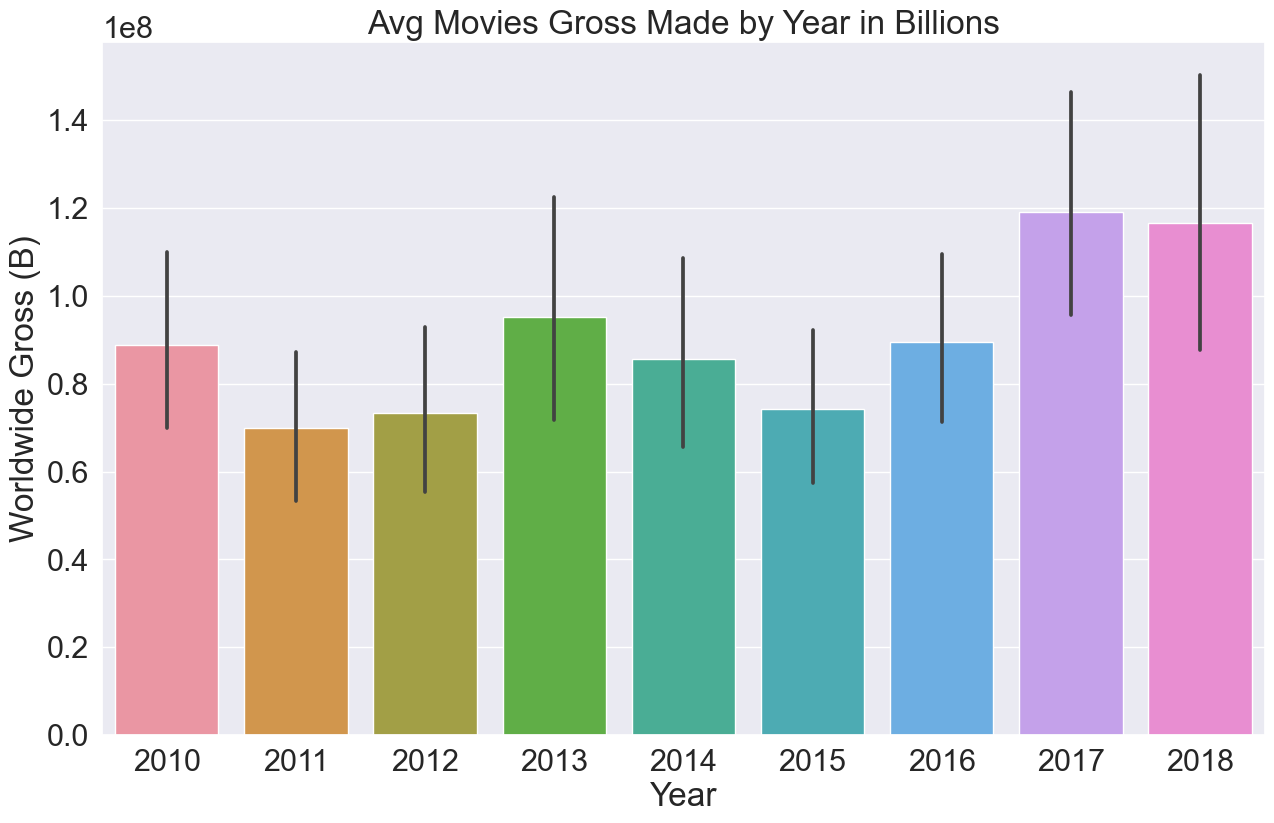

In [121]:
# A Seaborn boxplot comparing each year to the average worldwide gross
fig, ax = plt.subplots(figsize=(15,9))
sns.set(font_scale=2.0)
sns.set_palette("rocket")
sns.barplot(x = fm['year'], y = fm['worldwide_gross'], ax=ax);

ax.set_xlabel("Year")
ax.set_ylabel("Worldwide Gross (B)")
ax.set_title("Avg Movies Gross Made by Year in Billions")

plt.show()

In [122]:
# Includes rows where the "popularity" columnn is less than 60
subset_60p = fm.loc[fm['popularity'] < 60]
# Getting the top 5 most popular languages for movies 
lang_bar_df = subset_60p.groupby('original_language').median().sort_values(by = 'popularity', ascending = False).reset_index().head()

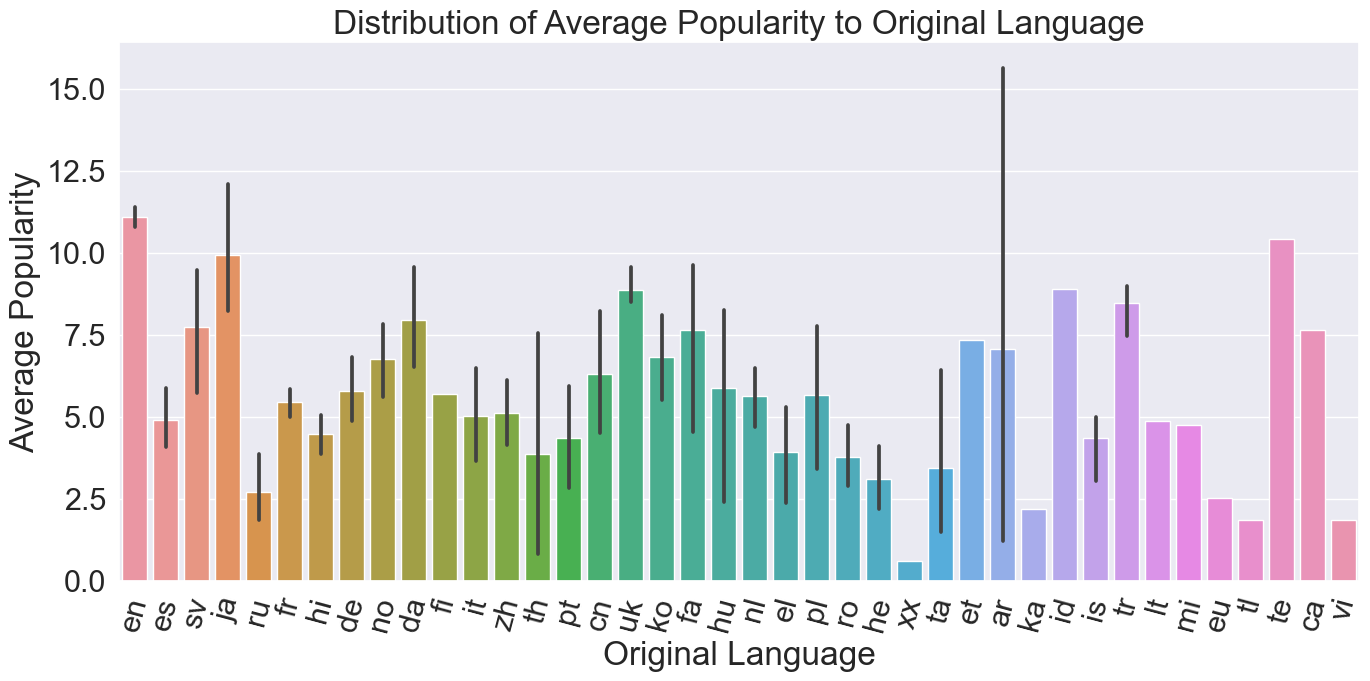

In [123]:
# A Seaborn barplot comparing the average popularity with each language
fig, ax = plt.subplots(figsize=(16,7))
sns.barplot(x = subset_60p['original_language'], y = subset_60p['popularity'])
fig.subplots_adjust(hspace=0.125, wspace=0.125)
ax.tick_params(axis='x', rotation=75)
ax.set_xlabel('Original Language')
ax.set_ylabel('Average Popularity')
ax.set_title('Distribution of Average Popularity to Original Language');

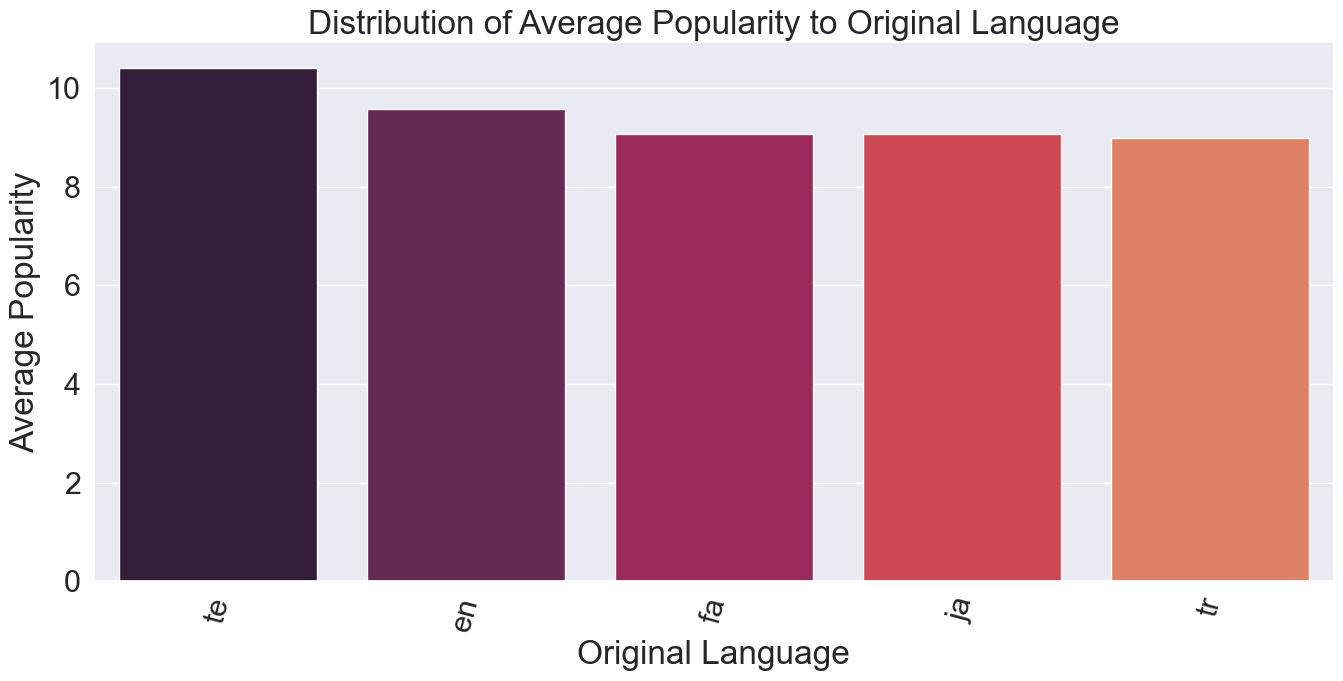

In [124]:
#A Seaborn barplot providing the top 5 most popular languages
fig, ax = plt.subplots(figsize=(16,7))
sns.barplot(x = lang_bar_df['original_language'], y = lang_bar_df['popularity'])
fig.subplots_adjust(hspace=0.125, wspace=0.125)
ax.tick_params(axis='x', rotation=75)
ax.set_xlabel('Original Language')
ax.set_ylabel('Average Popularity')
ax.set_title('Distribution of Average Popularity to Original Language');

In [125]:
# Including rows where the worldwide gross is greater than $300 million
subset_300m = fm.loc[fm['worldwide_gross'] >= 300000000]
# Finding the unique values of the "studio" column
subset_300m['studio'].unique()

array(['P/DW', 'Par.', 'WB', 'BV', 'Uni.', 'Sum.', 'Fox', 'Wein.', 'FoxS',
       'Sony', 'SGem', 'WB (NL)', 'LGF', 'LG/S', 'FR', 'FUN', 'UTV',
       'WGUSA'], dtype=object)

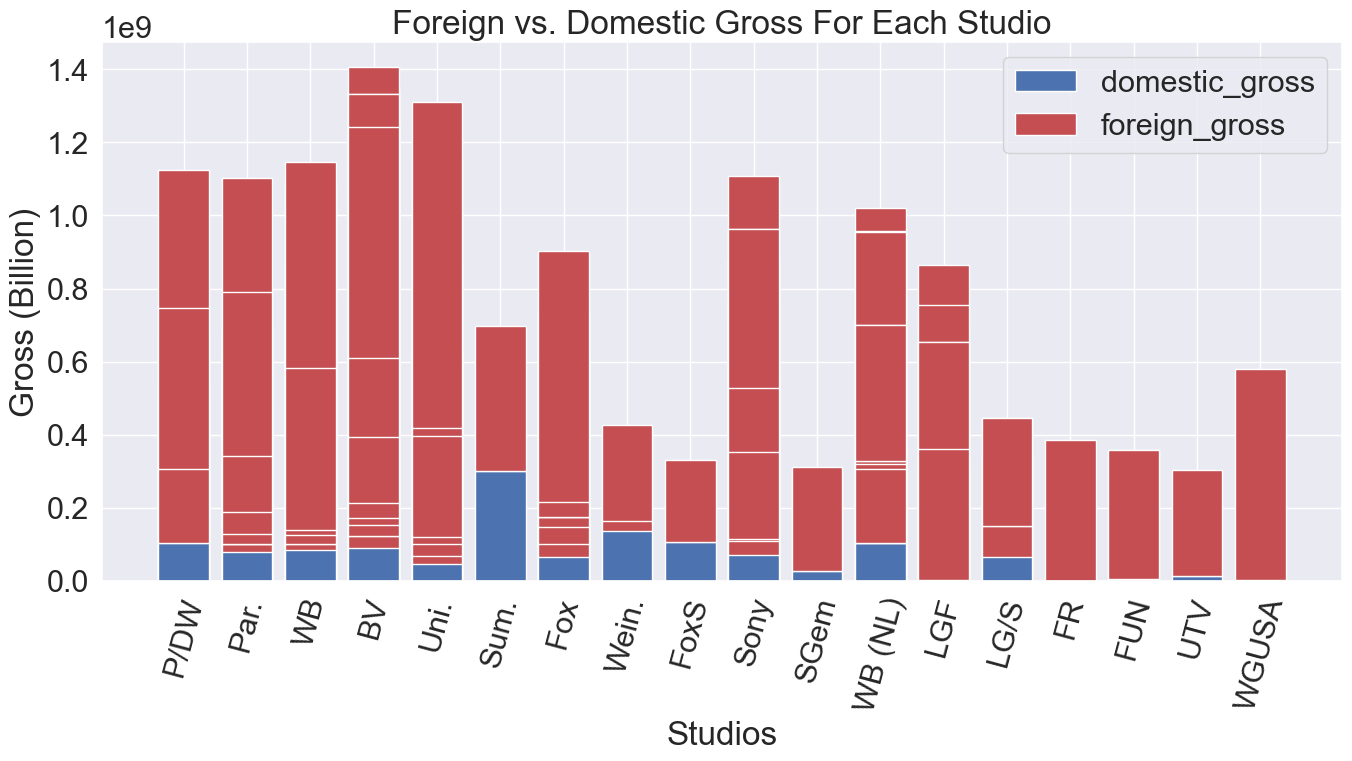

In [126]:
# Matplotlib barplot comparing the gross of each movie studio and splitting it by domestic/foreign gross
fig, ax = plt.subplots(figsize=(16,7))
ax.bar(x = subset_300m['studio'], height = subset_300m['domestic_gross'], label='domestic_gross', color='b')
ax.bar(x = subset_300m['studio'], height = subset_300m['foreign_gross'], label='foreign_gross', color='r', bottom = subset_300m['domestic_gross'])
ax.legend()
ax.tick_params(axis='x', rotation=75)
ax.set_xlabel('Studios')
ax.set_ylabel('Gross (Billion)')
ax.set_title('Foreign vs. Domestic Gross For Each Studio');

In [127]:
# Creating a variable "st" for the column "studio"
st = subset_300m['studio']

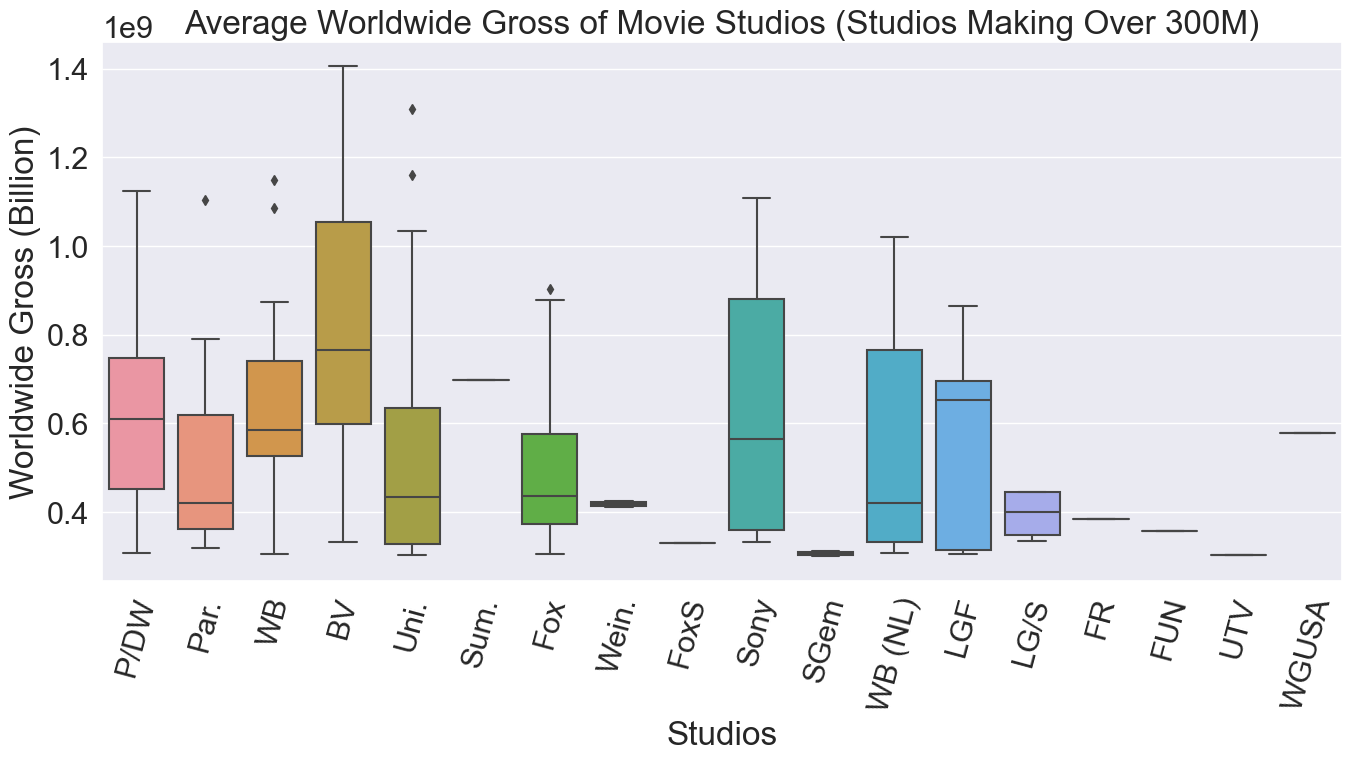

In [128]:
# A Seaborn boxplot comparing the movie studios and the worldwide gross
fig, ax = plt.subplots(figsize=(16,7))
sns.boxplot(x = st, y = subset_300m['worldwide_gross'])
sns.set(font_scale=2)
ax.tick_params(axis='x', rotation=75)
ax.set_xlabel('Studios')
ax.set_ylabel('Worldwide Gross (Billion)')
ax.set_title('Average Worldwide Gross of Movie Studios (Studios Making Over 300M)');

In [129]:
tn['release_date'] = pd.to_datetime(tn['release_date']).dt.year  # Getting the YEAR from release_date
tn['release_date'] = pd.to_numeric(tn['release_date'])           # Converting to numeric
tn = tn[tn['release_date'] > 1999]                               # Years above 1999

# Cleaning worldwide gross column 
                                                                 # Replacing symbols then to_numeric
tn['worldwide_gross'] = pd.to_numeric(tn['worldwide_gross'].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
tn['worldwide_gross'] = tn['worldwide_gross'] * 1                # All numbers to positive
tn = tn[(tn['worldwide_gross'] > 100000000) & (tn['worldwide_gross'] < 2000000000)]
                                                                # All worldwide_gross greater than 30000000

# Cleaning production budget column 
                                                                 # Replacing symbols then to_numeric
tn['production_budget'] = pd.to_numeric(tn['production_budget'].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
tn['production_budget'] = tn['production_budget'] * 1            # All numbers to positive
tn = tn[tn['production_budget'] > 0]                             # All production_budget greater than 0

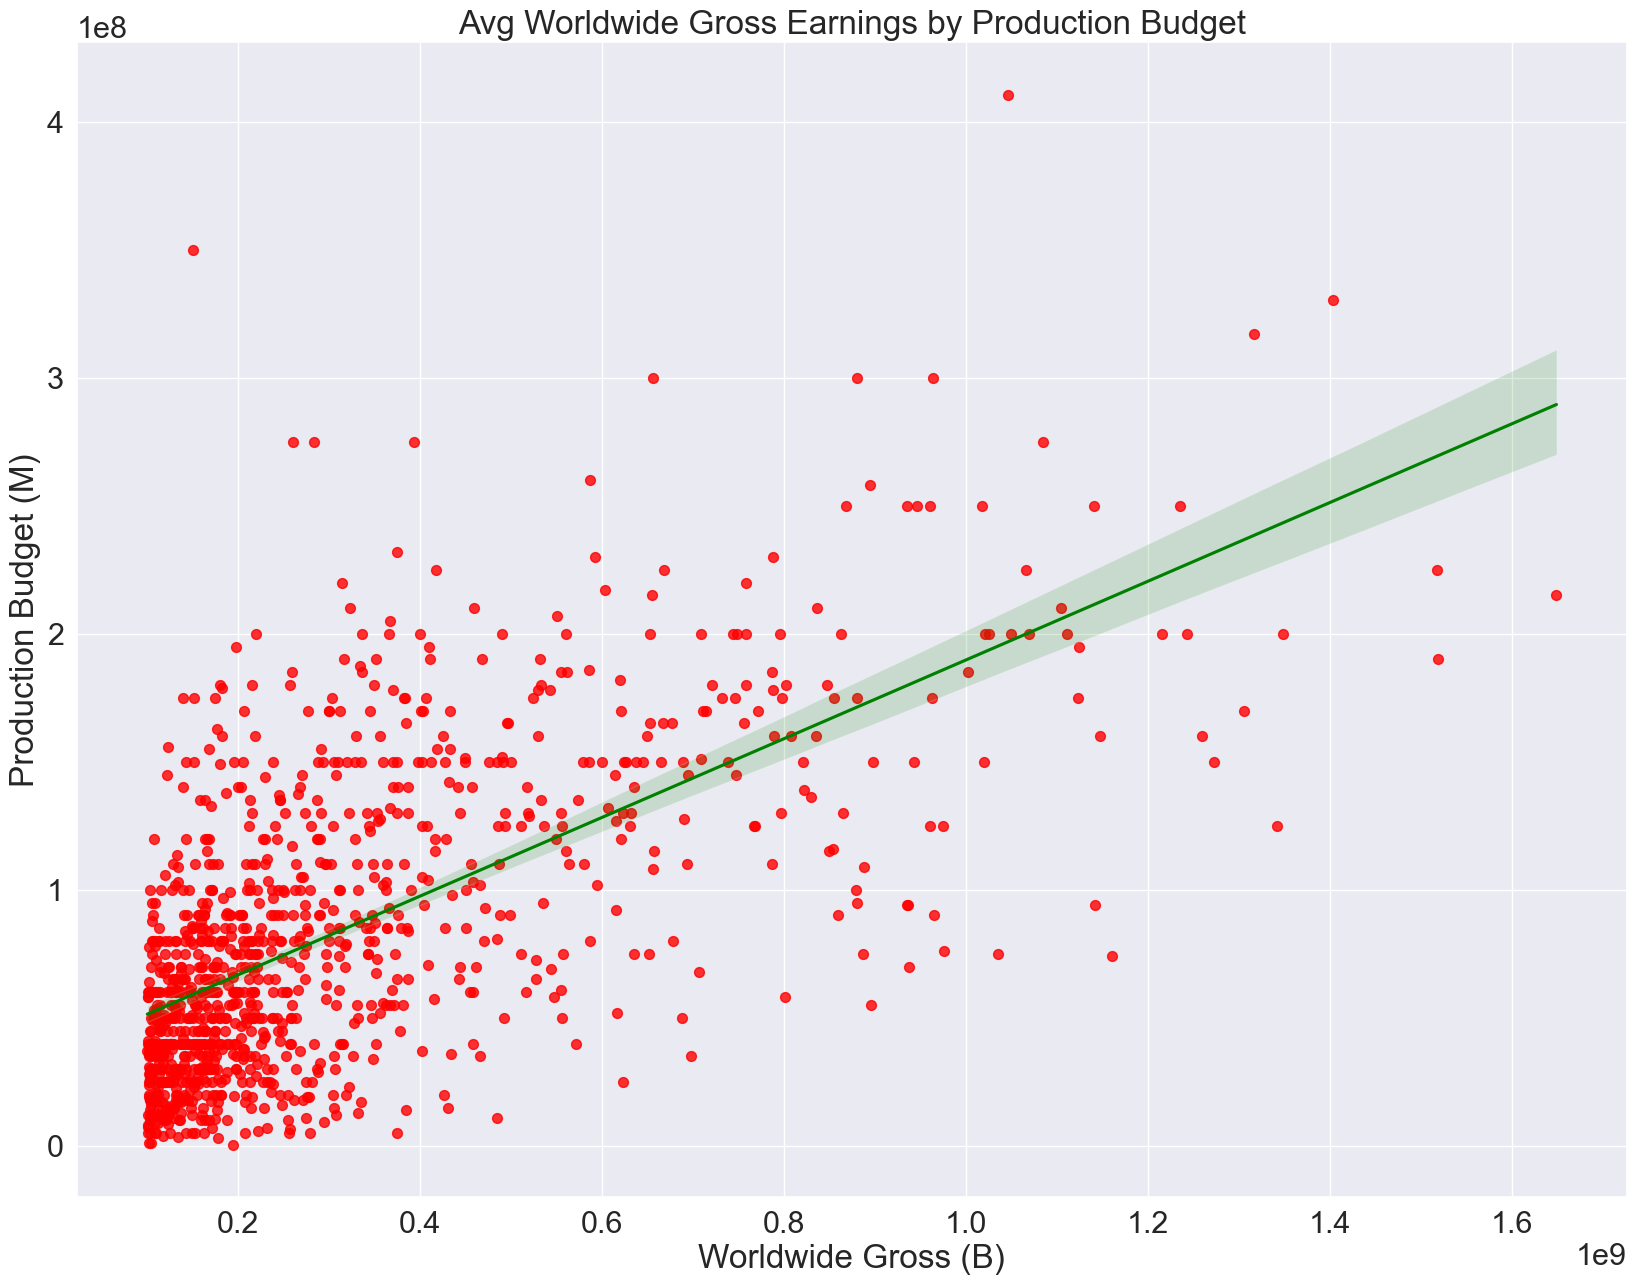

In [130]:
# production_budget / worldwide_gross correlation plot

fig, ax = plt.subplots(figsize=(20,15))
sns.regplot(x = tn['worldwide_gross'], y = tn['production_budget'], scatter=True, color="red", ci=95, scatter_kws={'s':50}, line_kws={'color':'green'})
sns.set(font_scale=2)

ax.set_xlabel("Worldwide Gross (B)")
ax.set_ylabel("Production Budget (M)")
ax.set_title("Avg Worldwide Gross Earnings by Production Budget")

plt.show()

In [131]:
# Getting the month out of the "release_date" column
tn_copy['release_date'] = pd.to_datetime(tn_copy['release_date'])
tn_copy['month'] = tn_copy['release_date'].dt.month
# Getting rid of '$' and ',' for worldwide gross & groupby month
tn_copy['worldwide_gross'] = tn_copy['worldwide_gross'].apply(lambda x: int(x.replace('$','').replace(',','')))
monthly_gross = tn_copy.groupby('month')['worldwide_gross'].sum()

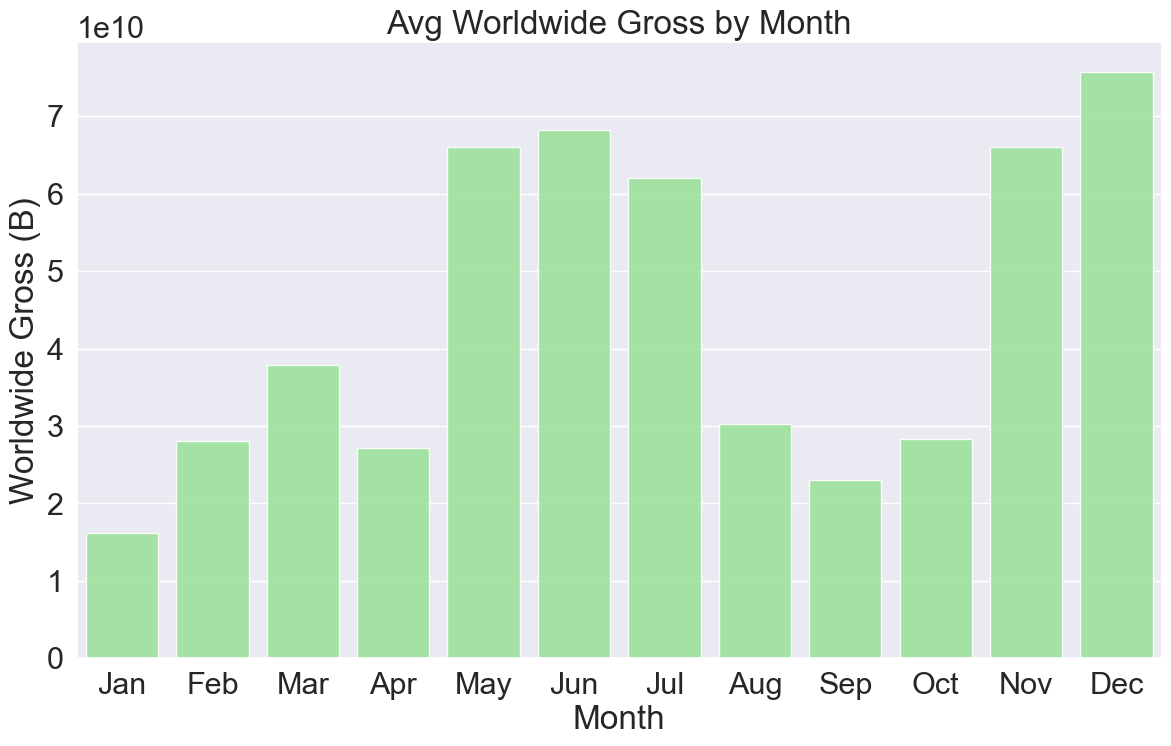

In [132]:
# Barplot comparing the worldwide gross with each month
import calendar

x = [calendar.month_abbr[i] for i in monthly_gross.index]
y = monthly_gross.values

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(x, y, color="lightgreen", alpha= 0.9)
ax.set_xlabel("Month")
ax.set_ylabel("Worldwide Gross (B)")
ax.set_title("Avg Worldwide Gross by Month")
plt.show()

In [133]:
# Inner merging the "imbd_principals" and "imdb_persons"
merged_imdb_people = pd.merge(imdb_principals, imdb_persons, how="inner", on='person_id')

In [134]:
# Inner merging (imdb_movie_akas and imdb_movie_ratings) & (akas_ratings_imdb and imdb_movie_basics)
akas_ratings_imdb = pd.merge(imdb_movie_akas, imdb_movie_ratings, how="inner", on='movie_id')
merged_imdb = pd.merge(akas_ratings_imdb, imdb_movie_basics, how="inner", on='movie_id')

In [135]:
# Splitting genres by comma and getting unique values
genres = merged_imdb["genres"].str.split(",").explode().unique()
genres

array(['Action', 'Adventure', 'Sci-Fi', 'Drama', 'Documentary', 'Romance',
       'Family', 'Fantasy', 'Crime', 'Thriller', 'Comedy', 'Mystery',
       'Musical', 'Animation', 'Horror', 'Sport', 'Music', 'History',
       'Biography', None, 'War', 'News', 'Western', 'Reality-TV',
       'Game-Show', 'Adult'], dtype=object)

In [136]:
# Groupby genres for average rating
rating_genre = merged_imdb[merged_imdb['genres'].isin(genres)].groupby("genres")["averagerating"].mean().sort_values()

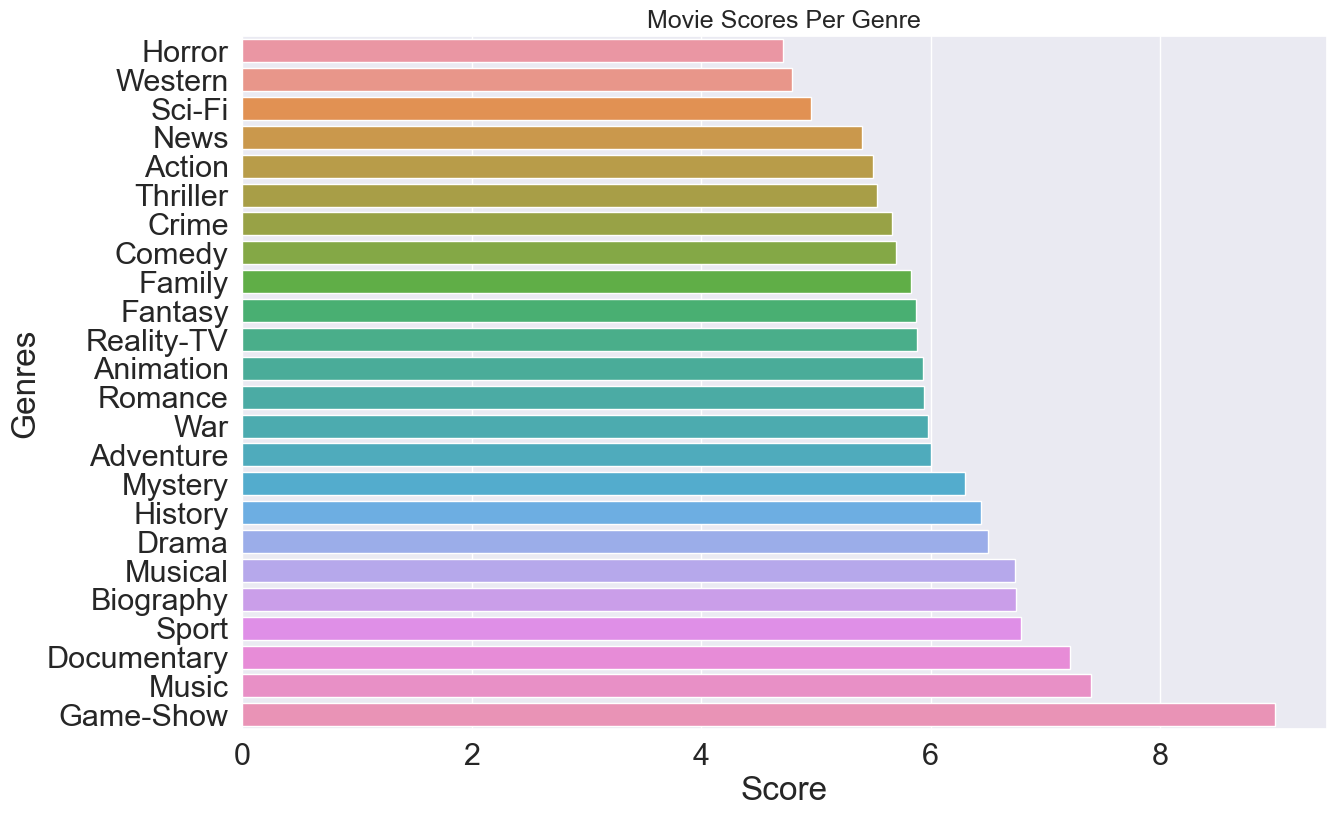

In [137]:
# Barplot comparing score with genres
x = rating_genre.values
y = rating_genre.index

fig, ax = plt.subplots(figsize=(14,9))
sns.set(font_scale=1.5)
sns.set_palette("rocket")
sns.barplot(x,y)

ax.set_xlabel("Score")
ax.set_ylabel("Genres")

ax.set_title("Movie Scores Per Genre") 
# ax.tick_params(axis='x', rotation=75)
plt.show()

In [138]:
# Inner merging rt_rev and rt
review_rating = pd.merge(rt_rev, rt, how = 'inner', on = 'id')

In [139]:
# Finding total null for the score
review_rating['rating_x'].isnull().sum()

13517

In [140]:
# Filtering the ratings in review_rating
filtered_review_rating = review_rating.dropna(subset = ['rating_x'])
filtered_review_rating = review_rating.dropna(subset = ['rating_y'])

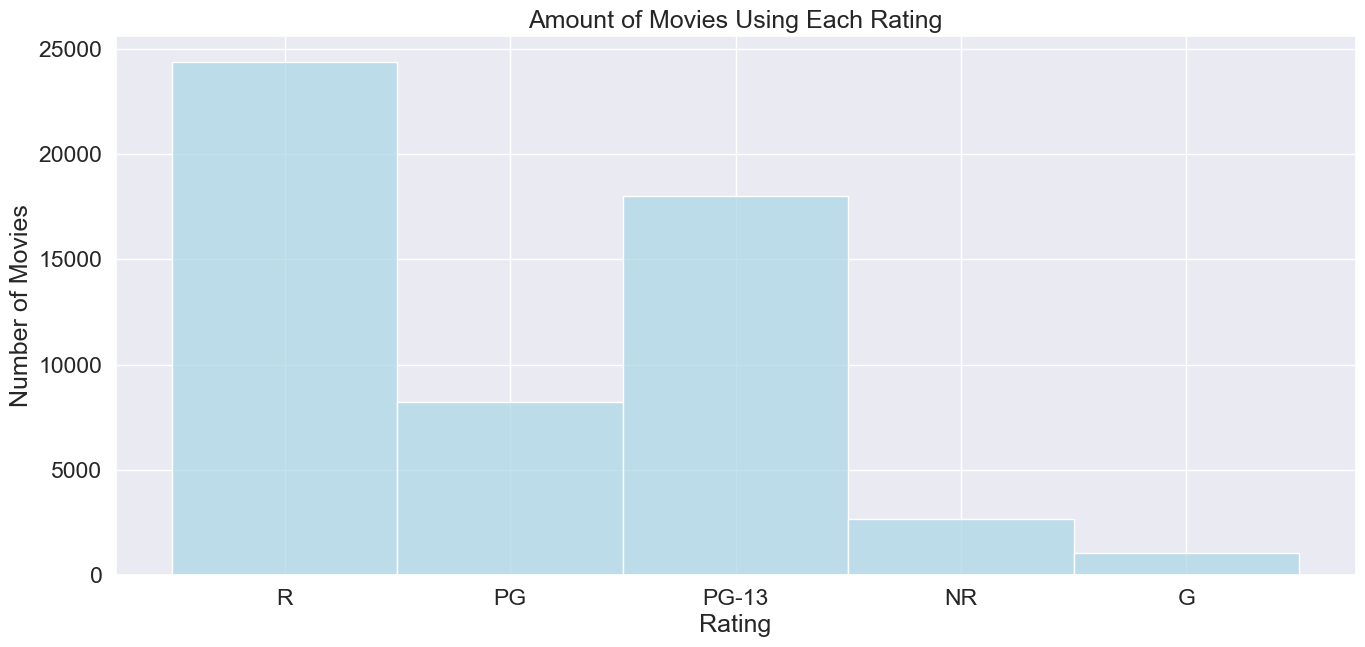

In [141]:
# Plot number of movies by rating
fig, ax = plt.subplots(figsize = (16,7))
sns.histplot(x = filtered_review_rating['rating_y'], color = "lightblue" ) 
ax.set_xlabel('Rating')
ax.set_ylabel('Number of Movies')
ax.set_title('Amount of Movies Using Each Rating');

In [142]:
# Genre codes needed to decode the genres in the genre ids column
genre_id = {28:'Action', 12:'Adventure', 16:'Animation', 35:'Comedy', 80:'Crime',
            99:'Documentary', 18:'Drama', 10751:'Family', 14:'Fantasy', 36:'History',
            27:'Horror', 10402:'Music', 9648:'Mystery', 10749:'Romance',
            878:'Science Fiction', 10770:'TV Movie', 53:'Thriller', 10752:'War',
            37:'Western'}

In [143]:
# Cleaning genre ids column
fm['genre_ids'] = fm['genre_ids'].apply(lambda x: x if not pd.isna(x) else None)

In [144]:
# This code maps genre ids to names, joins them and adds them as new column in a DataFrame.
import ast

fm_genres = fm[pd.notnull(fm['genre_ids'])]
fm_genres['genre_ids'] = fm_genres['genre_ids'].apply(lambda x: ast.literal_eval(x))
fm_genres['genre'] = fm_genres['genre_ids'].apply(lambda x: [genre_id[g] for g in x])
fm_genres['genre'] = fm_genres['genre'].apply(lambda x: ', '.join(x))

In [145]:
# Cleaning review_rating
review_rating.dropna(subset = ['genre'], inplace=True)
review_rating['genre'] = review_rating['genre'].apply(lambda x: str(x.replace('|',',').replace('and',',').replace(' , ',',')))
review_rating['year'] = review_rating.date.str.split(",").str[1].tolist()
review_rating.dropna(subset = ['theater_date'], inplace=True)
review_rating["theater_date"] = pd.to_datetime(review_rating["theater_date"], format= '%b %d, %Y').dt.strftime('%Y-%m-%d')

In [146]:
# Cleaning
filtered_rating = review_rating.drop_duplicates(subset='synopsis')
filtered_rating = filtered_rating.dropna(subset=['rating_y'])
filtered_rating.rename(columns={'theater_date': 'release_date'}, inplace=True)

In [147]:
# Inner merging dataframes
rating_lang = pd.merge(fm_genres, filtered_rating, how="inner", on=['genre', 'release_date'])

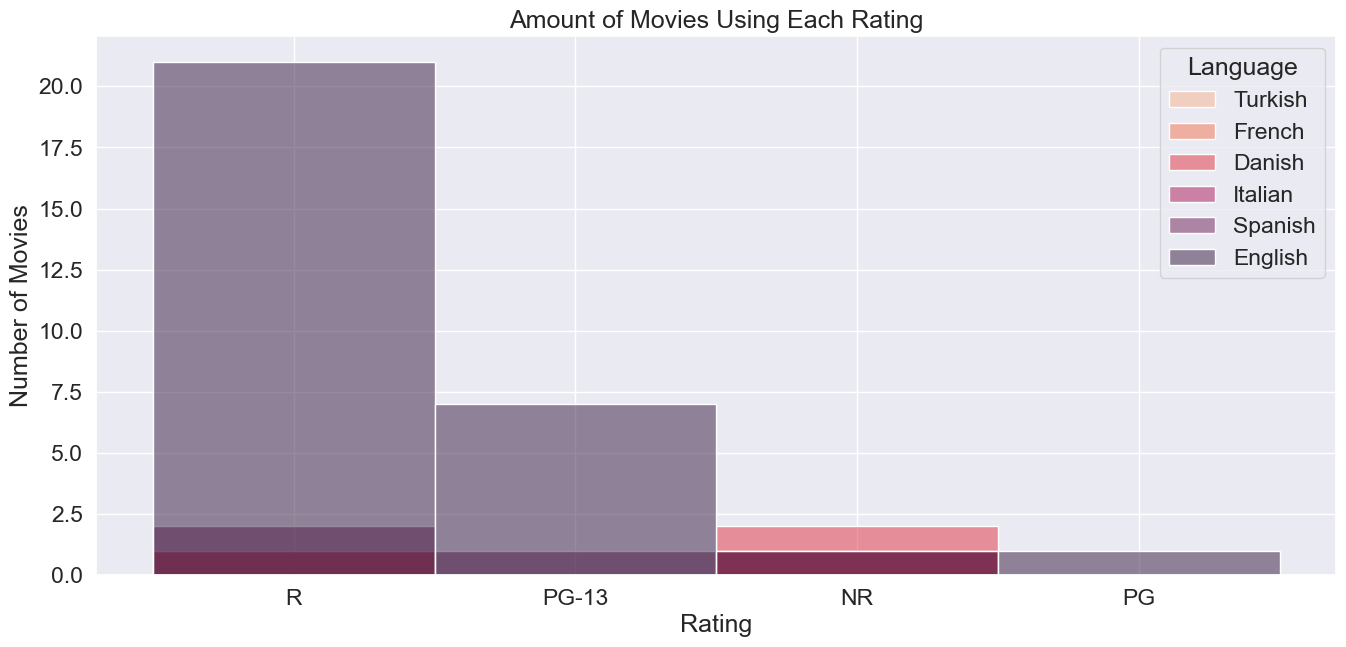

In [148]:
# Looking at the number of movies per genre for every movie
fig, ax = plt.subplots(figsize = (16,7))
sns.histplot(x = rating_lang['rating_y'], hue = rating_lang['original_language'])
plt.legend(title='Language', loc = 'upper right', labels=['Turkish', 'French', 'Danish', 'Italian', 'Spanish', 'English'])
ax.set_xlabel('Rating')
ax.set_ylabel('Number of Movies')
ax.set_title('Amount of Movies Using Each Rating');

In [149]:
# Cleaning
filtered_fm_genres = fm_genres.drop_duplicates(subset='title')

In [150]:
# Cleaning and fixing some columns name
del merged_imdb["title"]
filtered_imdb = merged_imdb.drop_duplicates(subset='original_title')
filtered_imdb.rename(columns = {'original_title': 'title'}, inplace=True)

In [151]:
# Inner merging into a new DataFrame
fm_genres_imdb = pd.merge(fm_genres, filtered_imdb, how="inner", on=['title'])

In [152]:
# Unique genres
all_genres = fm_genres_imdb["genres"].str.split(",").explode().unique()
all_genres

array(['Action', 'Adventure', 'Animation', 'Sci-Fi', 'Comedy', 'Family',
       'Thriller', 'Drama', 'Fantasy', 'Mystery', 'Biography', 'History',
       'Romance', 'Crime', 'Horror', 'Western', 'War', 'Sport',
       'Documentary', 'Music', 'Musical', 'News'], dtype=object)

In [153]:
# Getting a DataFrame with worldwide gross and runtime minutes, grouped by unique genres
genre_gross = fm_genres_imdb[fm_genres_imdb['genres'].isin(all_genres)].groupby("genres")["worldwide_gross", "runtime_minutes"].mean().sort_values(by=['worldwide_gross', 'runtime_minutes'])
genre_gross.dropna(inplace=True)

genre_gross["runtime_minutes"] = genre_gross["runtime_minutes"].round(1)
genre_gross["worldwide_gross"] = genre_gross["worldwide_gross"].round()
genre_gross

,worldwide_gross,runtime_minutes
genres,,
Fantasy,1546000.0,81.0
Documentary,12233091.0,87.4
Drama,18332187.0,106.0
Action,38267936.0,112.1
Thriller,38499236.0,90.7
Crime,65469367.0,112.3
Comedy,68172363.0,97.7
Horror,79385458.0,88.8
Animation,271951099.0,86.0


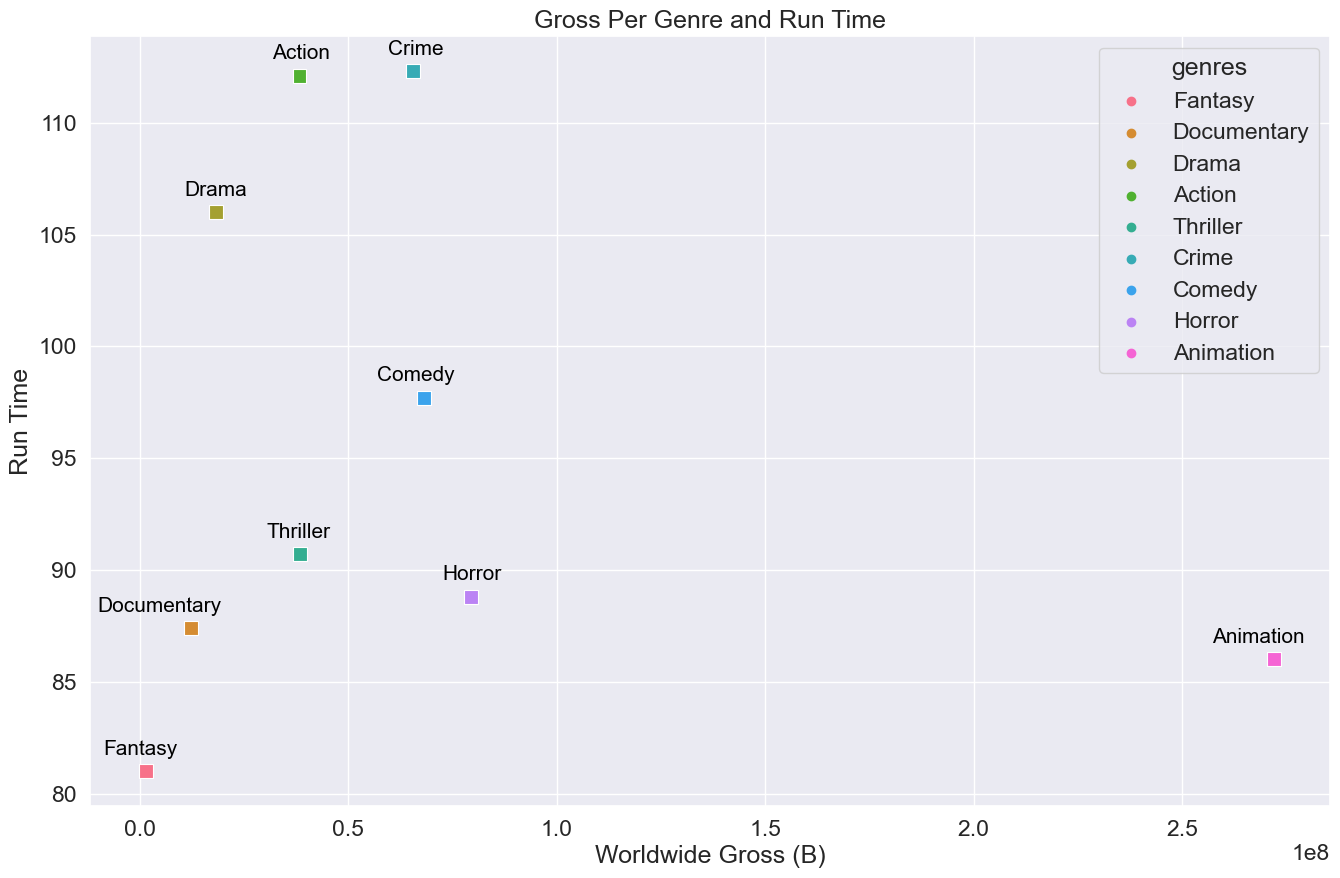

In [154]:
# looking at what genres make the most money and their average runtime
x1 = genre_gross["worldwide_gross"]
y2 = genre_gross["runtime_minutes"]

fig, ax = plt.subplots(figsize=(16,10))
sns.set(font_scale=1.5)
sns.set_palette("rocket")
sns.scatterplot(x=x1, y=y2, hue=genre_gross.index,  marker='s', color='red', s=100)

ax.set_xlabel("Worldwide Gross (B)")
ax.set_ylabel("Run Time")
ax.set_title("Gross Per Genre and Run Time")

for genre in genre_gross.index:
    genre_abbr = genre
    x = genre_gross.loc[genre, "worldwide_gross"]
    y = genre_gross.loc[genre, "runtime_minutes"]
    ax.annotate(genre_abbr, xy=(x, y), xytext=(22, 12), textcoords='offset points', ha='right', fontsize=15, color='black')

plt.show()

In [155]:
# Cleaning
rating = rt.dropna(axis=0, subset=['theater_date'])

In [156]:
# Cleaning
rating['runtime'] = rating['runtime'].apply(lambda x: int(x.replace('minutes',''))if isinstance(x, str) else x)

In [157]:
mean_runtime = rating['runtime'].mean()

In [158]:
# Filling NA values with the runtime mean and getting only the movies made in 2010 and above
rating['runtime'].fillna(value=mean_runtime, inplace=True)
subset_2000 = rating[rating.theater_date.str[-4:].astype(int)>=2010]
year = subset_2000.theater_date.str.split(",").str[1].tolist()
year = [int(i) for i in year]

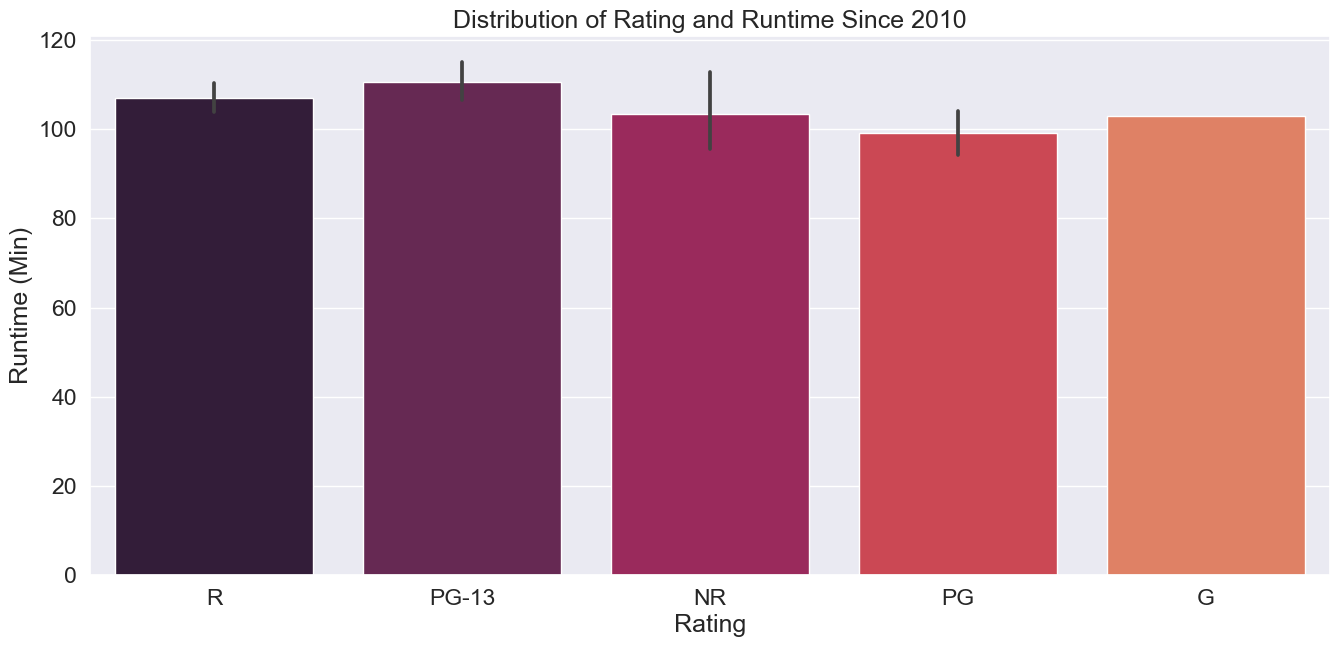

In [159]:
# looking at the distribution of runtime by rating
fig, ax = plt.subplots(figsize=(16,7))
sns.barplot(x = subset_2000['rating'], y = subset_2000['runtime'])
ax.set_xlabel('Rating')
ax.set_ylabel('Runtime (Min)')
ax.set_title('Distribution of Rating and Runtime Since 2010');

In [160]:
# Merging DataFrames on movie id
run_rate = pd.merge(imdb_movie_basics, imdb_movie_ratings, how = 'inner', on = 'movie_id')

In [161]:
# Sorting values of the new DataFrame
run_rate.sort_values(by=['runtime_minutes'], ascending=False)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
70280,tt8273150,Logistics,Logistics,2012,51420.0,Documentary,5.0,17
27683,tt2659636,Modern Times Forever,Modern Times Forever,2011,14400.0,Documentary,6.2,69
15171,tt2008009,The Clock,The Clock,2010,1440.0,Drama,8.9,219
71441,tt8677246,Bullfighting Memories,Bullfighting Memories,2017,1100.0,"Comedy,History",8.6,5
72424,tt9047474,La flor,La flor,2018,808.0,"Drama,Fantasy,Musical",8.5,100
...,...,...,...,...,...,...,...,...
73828,tt9899290,Band Together with Logic,Band Together with Logic,2019,NaN,Documentary,8.7,10
73830,tt9899850,The Agitation,Ashoftegi,2019,NaN,"Drama,Thriller",4.9,14
73844,tt9905796,July Kaatril,July Kaatril,2019,NaN,Romance,9.0,5
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8


In [162]:
mean_run = run_rate['runtime_minutes'].mean()

In [163]:
# Filling NAs with mean runtime
run_rate['runtime_minutes'].fillna(value=mean_run, inplace=True)

In [164]:
# Filtering by movies shorter than 200 minutes
subset_run = run_rate.loc[run_rate['runtime_minutes'] < 200]
subset_run

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00000,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,94.65404,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00000,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.00000,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,94.65404,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,94.65404,None,6.6,5


In [165]:
# Creating new variables for the plot
runt = subset_run['runtime_minutes']
ar = subset_run['averagerating']

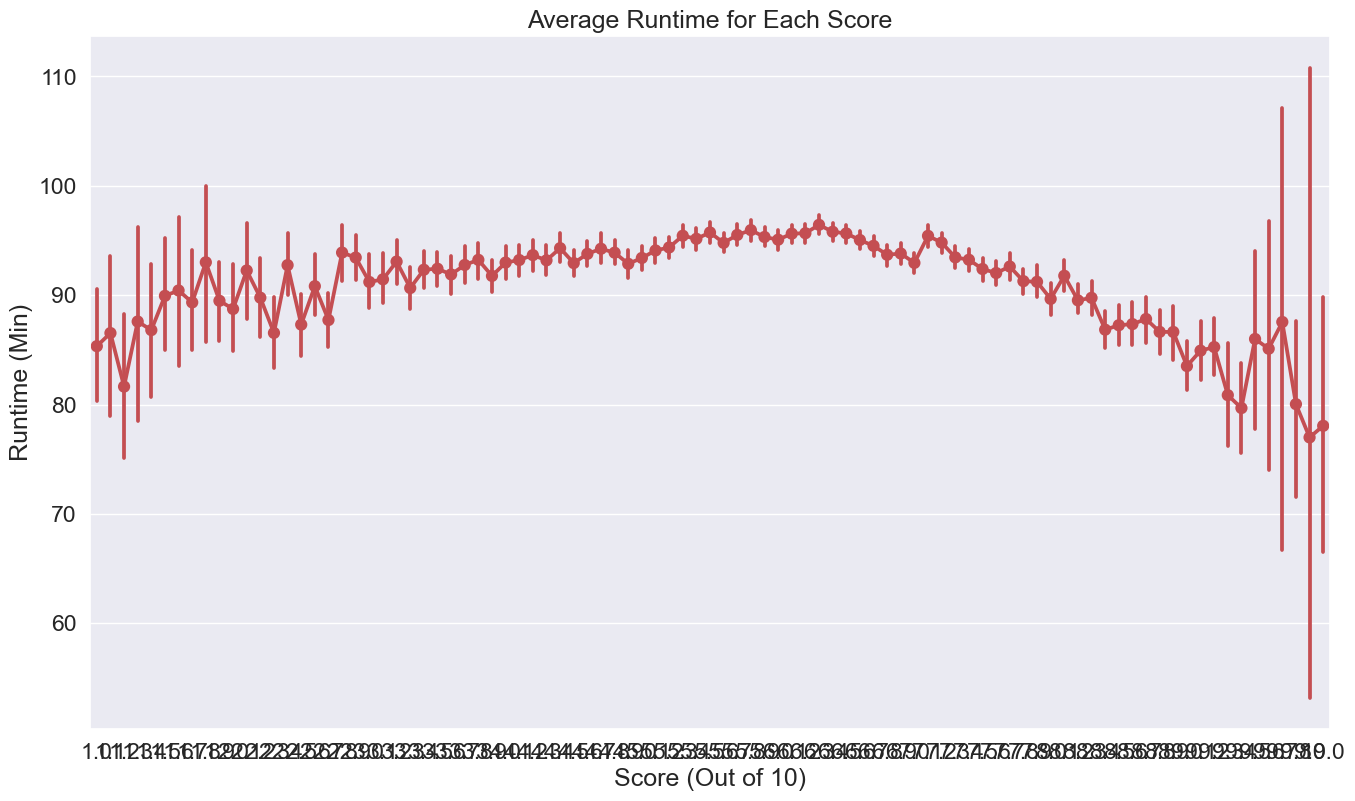

In [166]:
# Looking at the average runtime for each score
fig, ax = plt.subplots(figsize=(16,9))
sns.pointplot(x = ar, y = runt, color = 'r')
ax.set_xlabel('Score (Out of 10)')
ax.set_ylabel('Runtime (Min)')
ax.set_title('Average Runtime for Each Score');